In [ ]:
import tarfile
import os
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
import math

In [ ]:
# Path to the tar.gz file
tar_file_path = "ag_news_csv.tar.gz"

# Extracting the tar.gz file
with tarfile.open(tar_file_path, "r:gz") as tar:
    tar.extractall()

# List the extracted files
extracted_files = os.listdir()

In [ ]:
train = pd.read_csv('/content/ag_news_csv/train.csv')
test = pd.read_csv('/content/ag_news_csv/test.csv')

In [ ]:
train.head()

,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again."
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
2,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
3,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
4,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...


In [ ]:
test.head()

,3,Fears for T N pension after talks,Unions representing workers at Turner Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
0,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
1,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
2,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
3,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
4,4,Open Letter Against British Copyright Indoctri...,The British Department for Education and Skill...


In [ ]:
train.describe()

,3
count,119999.000000
mean,2.499996
std,1.118042
min,1.000000
25%,1.500000
50%,2.000000
75%,3.500000
max,4.000000


In [ ]:
test.describe()

,3
count,7599.000000
mean,2.499934
std,1.118166
min,1.000000
25%,1.500000
50%,2.000000
75%,3.500000
max,4.000000


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119999 entries, 0 to 119998
Data columns (total 3 columns):
 #   Column                                                                                          Non-Null Count   Dtype 
---  ------                                                                                          --------------   ----- 
 0   3                                                                                               119999 non-null  int64 
 1   Wall St. Bears Claw Back Into the Black (Reuters)                                               119999 non-null  object
 2   Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.  119999 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 3 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                           --------------  ----- 
 0   3                                                                                                                                7599 non-null   int64 
 1   Fears for T N pension after talks                                                                                                7599 non-null   object
 2   Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.  7599 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.2+ KB


In [ ]:
train.columns
test.columns

Index(['3', 'Fears for T N pension after talks',
       'Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.'],
      dtype='object')

In [ ]:
# Preprocess the text data
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Load the data with manual column names
column_names = ['label', 'title', 'description']
train = pd.read_csv('/content/ag_news_csv/train.csv', names=column_names)
test = pd.read_csv('/content/ag_news_csv/test.csv', names=column_names)

# Display the first few rows of the combined DataFrame
train.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
# Check for missing values
print("Missing Values in Training Dataset:")
print(train.isnull().sum())

print("\nMissing Values in Test Dataset:")
print(test.isnull().sum())

Missing Values in Training Dataset:
label          0
title          0
description    0
dtype: int64

Missing Values in Test Dataset:
label          0
title          0
description    0
dtype: int64


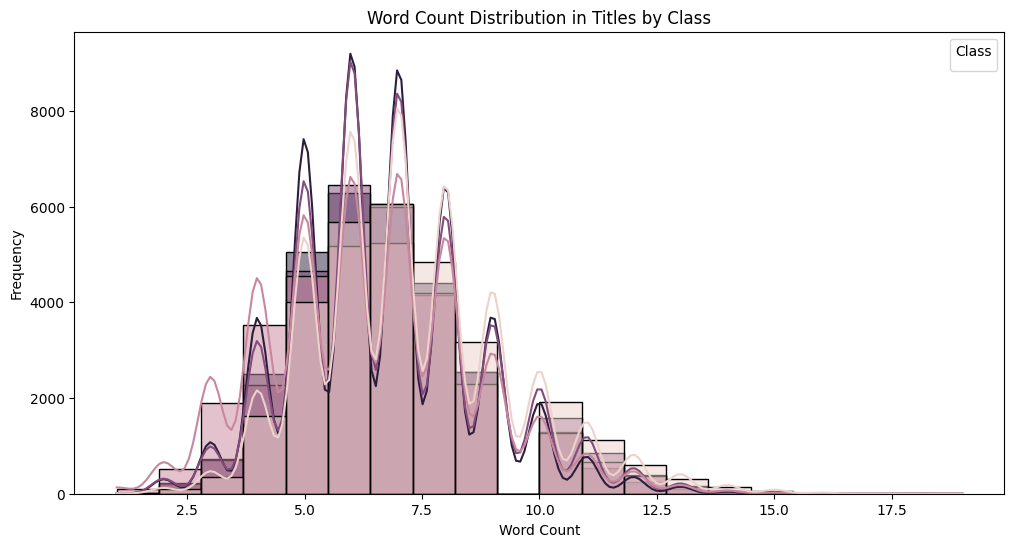

In [ ]:
# Calculate word count in titles
train['word_count'] = train['title'].apply(lambda x: len(x.split()))

# Visualization 1: Word Count Distribution in Titles by Class
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='word_count', hue='label', bins=20, kde=True)
plt.title('Word Count Distribution in Titles by Class')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(title='Class')
plt.show()

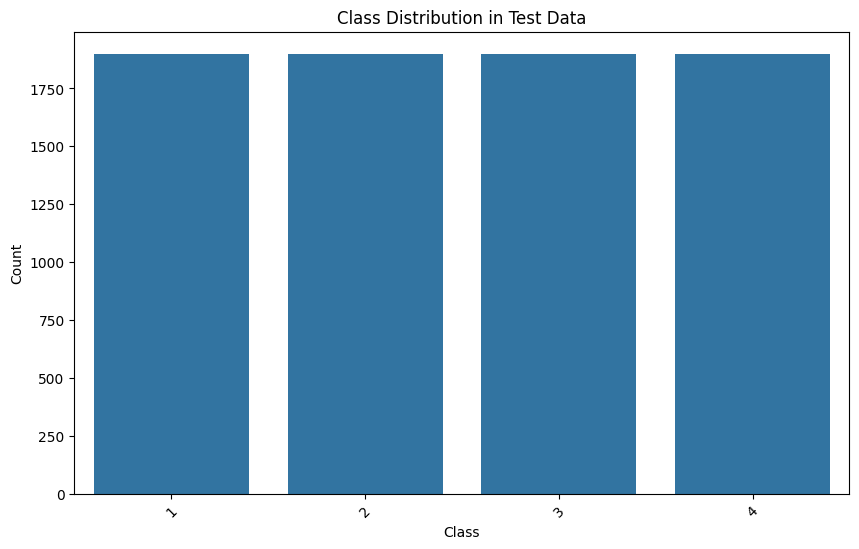

In [ ]:
# Visualization 2: Class Distribution in Test Data
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=test)
plt.title('Class Distribution in Test Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

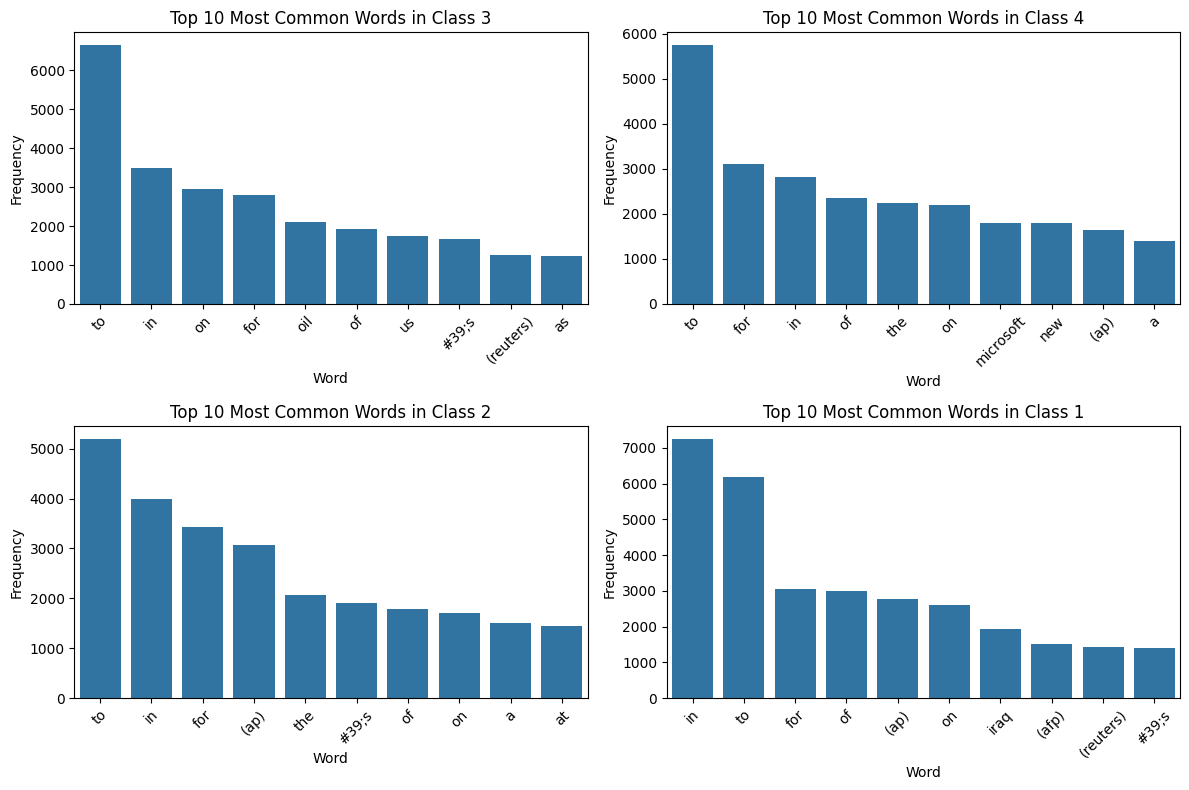

In [ ]:
# Import Counter module
from collections import Counter

# Visualization 3: Top 10 Most Common Words by Class
plt.figure(figsize=(12, 8))
for i, label in enumerate(train['label'].unique(), 1):
    plt.subplot(2, 2, i)
    word_freq_class = Counter(' '.join(train[train['label'] == label]['title']).lower().split())
    top_words_class = word_freq_class.most_common(10)
    top_words_df_class = pd.DataFrame(top_words_class, columns=['Word', 'Frequency'])
    sns.barplot(x='Word', y='Frequency', data=top_words_df_class)
    plt.title(f'Top 10 Most Common Words in Class {label}')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

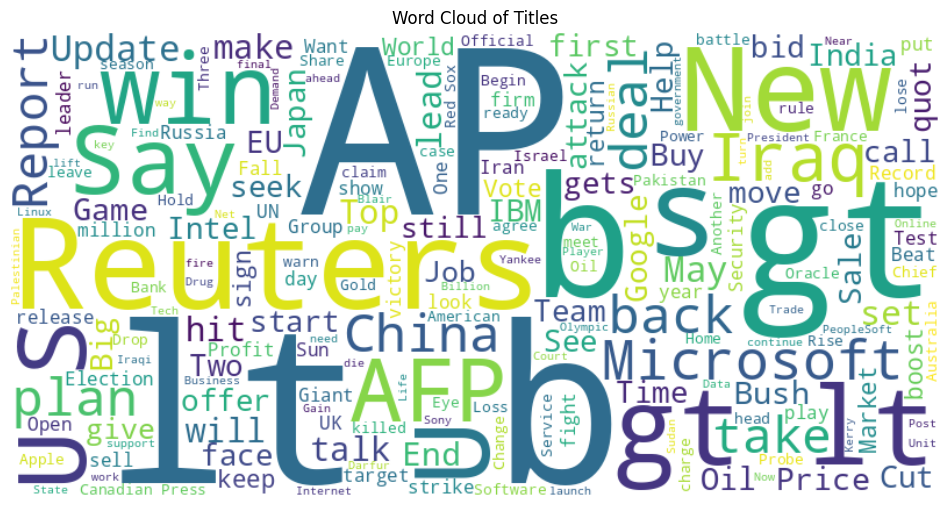

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Visualization 4: Word Cloud of Titles
all_titles = ' '.join(train['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Titles')
plt.axis('off')
plt.show()

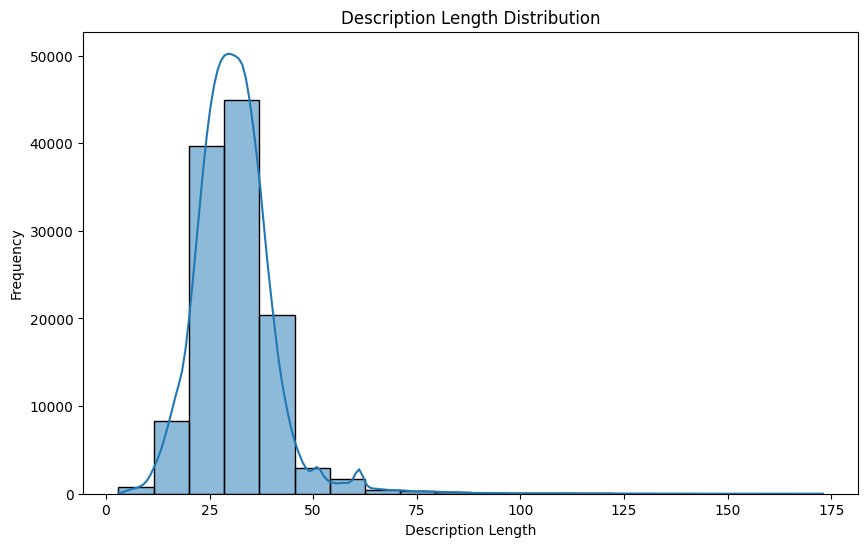

In [ ]:
# Visualization 5: Description Length Distribution
train['description_length'] = train['description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data=train, x='description_length', bins=20, kde=True)
plt.title('Description Length Distribution')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()

In [ ]:
word_embeddings = torchtext.vocab.GloVe(name='6B', dim=100)

# Modify the preprocess function to convert tokens to indices
def preprocess_text_to_indices(text):
    tokenizer = get_tokenizer("basic_english")
    tokens = tokenizer(text.lower())
    # Filter and convert to indices, using 0 for OOV
    indices = [word_embeddings.stoi.get(token, 0) for token in tokens if token not in stop_words and token not in string.punctuation]
    return indices

# Adjusting labels to start from 0
train['label'] -= 1
test['label'] -= 1

# Preprocess the data
train['title_indices'] = train['title'].apply(preprocess_text_to_indices)
test['title_indices'] = test['title'].apply(preprocess_text_to_indices)
train.head()

.vector_cache/glove.6B.zip: 862MB [02:39, 5.40MB/s]                           
100%|█████████▉| 399999/400000 [00:24<00:00, 16648.89it/s]


,label,title,description,word_count,description_length,title_indices
0,2,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",9,12,"[1015, 2696, 4509, 21844, 137, 521, 10851]"
1,2,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,6,30,"[23499, 2146, 981, 1196, 7583, 10851]"
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,7,29,"[316, 427, 6237, 895, 4091, 10851]"
3,2,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,9,27,"[233, 25507, 316, 1897, 444, 482, 4523, 10851]"
4,2,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",13,24,"[316, 468, 14268, 15039, 384, 10956, 50, 14875..."


In [ ]:
# Extract features and labels
X_train = list(train['title_indices'])
y_train = train['label'].values

X_test_now = list(test['title_indices'])
y_test_now = test['label'].values

# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test_now)

In [ ]:
# Split original test data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test_now, y_test_encoded, test_size=0.5, random_state=42)

In [ ]:
# Padding function
def pad_sequences(sequences, maxlen):
    padded_sequences = np.zeros((len(sequences), maxlen))
    for i, seq in enumerate(sequences):
        if len(seq) > 0:
            padded_sequences[i, -len(seq):] = seq[:maxlen]
    return padded_sequences

# Find max length for padding
max_len = max(max(len(s) for s in X_train), max(len(s) for s in X_val), max(len(s) for s in X_test))

# Pad sequences
X_train_padded = pad_sequences(X_train, max_len)
X_val_padded = pad_sequences(X_val, max_len)
X_test_padded = pad_sequences(X_test, max_len)

In [ ]:
# Convert to tensor and create datasets and loaders
train_dataset = TensorDataset(torch.tensor(X_train_padded, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val_padded, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)
print("Train DataLoader:")
print("Number of batches:", len(train_loader))
print("Batch size:", train_loader.batch_size)
print("Total samples:", len(train_loader.dataset))
print()

print("Validation DataLoader:")
print("Number of batches:", len(val_loader))
print("Batch size:", val_loader.batch_size)
print("Total samples:", len(val_loader.dataset))
print()

print("Test DataLoader:")
print("Number of batches:", len(test_loader))
print("Batch size:", test_loader.batch_size)
print("Total samples:", len(test_loader.dataset))
print()

Train DataLoader:
Number of batches: 3750
Batch size: 32
Total samples: 120000

Validation DataLoader:
Number of batches: 119
Batch size: 32
Total samples: 3800

Test DataLoader:
Number of batches: 119
Batch size: 32
Total samples: 3800



## Base Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.positional_encoding = nn.Parameter(self._generate_positional_encoding(max_seq_length, embedding_matrix.size(1)))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_matrix.size(1), nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(embedding_matrix.size(1), num_classes)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids) + self.positional_encoding[:input_ids.size(1), :]
        transformer_output = self.transformer_encoder(embeddings)
        cls_output = transformer_output.mean(dim=1)  # Use the mean of all tokens as the representation
        logits = self.output_layer(cls_output)
        return logits

    def _generate_positional_encoding(self, length, dim):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
        positional_encoding = torch.zeros(length, dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

In [ ]:
num_classes = 4
nhead = 4
num_encoder_layers = 6
dim_feedforward = 2048
max_seq_length = max_len

# Instantiate the model
model_base = TransformerClassifier(word_embeddings.vectors, num_classes, nhead, num_encoder_layers, dim_feedforward, max_seq_length)
model_base

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerClassifier(
  (embedding): Embedding(400000, 100)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the GPU
model_base.to(device)

# Move the data loaders to the GPU
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, pin_memory=True)

Using device: cuda


In [ ]:
num_epochs = 10

# Define your loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# Lists to store epoch-wise values
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model_base.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    # Define the optimizer
    optimizer = optim.SGD(model_base.parameters(), lr=0.001, momentum=0.9)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model_base(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        running_train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

    # Calculate average training loss and accuracy for the epoch
    average_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions

    # Validation
    model_base.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():  # No need to track gradients for validation
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_base(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            # Calculate accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_predictions += val_labels.size(0)

    # Calculate average validation loss and accuracy for the epoch
    average_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val_predictions / total_val_predictions

    print(f"Epoch {epoch+1}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy}")

    # Store values for plotting
    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1, Train Loss: 0.7045397038062413, Train Accuracy: 0.7381083333333334, Val Loss: 0.5381422229424244, Val Accuracy: 0.8089473684210526
Epoch 2, Train Loss: 0.5017347353776296, Train Accuracy: 0.8263833333333334, Val Loss: 0.5020600638720167, Val Accuracy: 0.8221052631578948
Epoch 3, Train Loss: 0.4728277548134327, Train Accuracy: 0.8356916666666667, Val Loss: 0.4601696725903439, Val Accuracy: 0.8381578947368421
Epoch 4, Train Loss: 0.44971503751476605, Train Accuracy: 0.8438083333333334, Val Loss: 0.4515016831520225, Val Accuracy: 0.8460526315789474
Epoch 5, Train Loss: 0.43495160095294316, Train Accuracy: 0.8492166666666666, Val Loss: 0.43034627488931687, Val Accuracy: 0.8528947368421053
Epoch 6, Train Loss: 0.42270061753988264, Train Accuracy: 0.8548083333333333, Val Loss: 0.4265224483458936, Val Accuracy: 0.8542105263157894
Epoch 7, Train Loss: 0.41161486189564067, Train Accuracy: 0.8581833333333333, Val Loss: 0.4253760339582668, Val Accuracy: 0.8555263157894737
Epoch 8, Train 

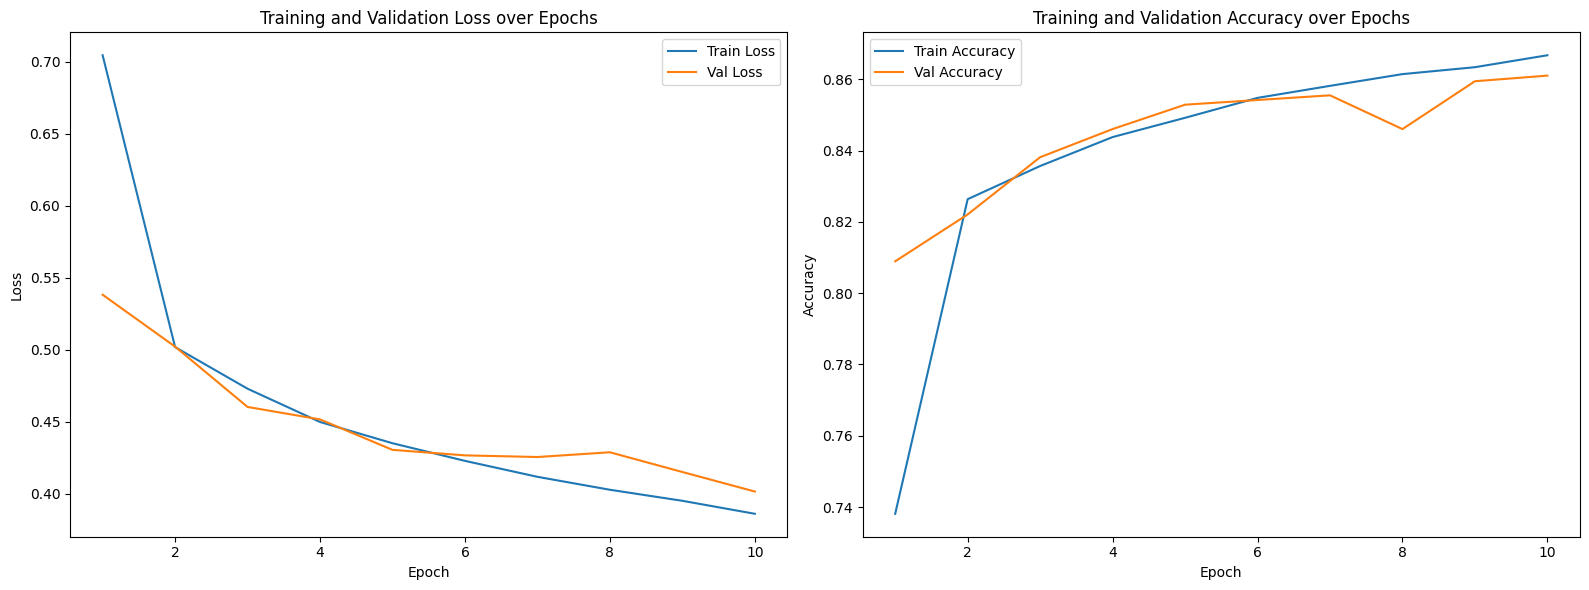

In [ ]:
# Plotting the graph
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the test set
model_base.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_base(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_base(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {average_test_loss}, Test Accuracy: {test_accuracy}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
print(f"\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

Test Loss: 0.3793294616356617, Test Accuracy: 0.8678947368421053

Confusion Matrix:
[[838  35  46  26]
 [ 39 883  28  12]
 [ 51  23 753  82]
 [ 40  22  98 824]]

Precision: 0.8681742910725166, Recall: 0.8678947368421053, F1 Score: 0.8678926874740904


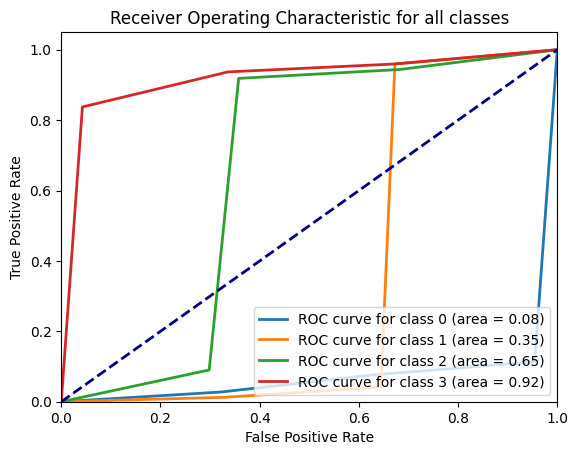

In [ ]:
plt.figure()
for i in range(4):  # Assuming there are four classes
    positive_class = i
    binary_labels = np.array([1 if label == positive_class else 0 for label in all_labels])
    fpr, tpr, _ = roc_curve(binary_labels, all_predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve for class {} (area = {:.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all classes')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Define a file path to save the model weights
model_path = "transformer_model_base.pth"

# Save the model weights
torch.save(model_base.state_dict(), model_path)

print("Training complete. Model weights saved.")

Training complete. Model weights saved.


## Dropout

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerClassifierDroupout(nn.Module):
    def __init__(self, embedding_matrix, num_classes, nhead, num_encoder_layers, dim_feedforward, max_seq_length, dropout_rate=0.1):
        super(TransformerClassifierDroupout, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.positional_encoding = nn.Parameter(self._generate_positional_encoding(max_seq_length, embedding_matrix.size(1)))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_matrix.size(1), nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(embedding_matrix.size(1), num_classes)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids) + self.positional_encoding[:input_ids.size(1), :]
        embeddings = self.dropout(embeddings)  # Apply dropout after the embedding layer
        transformer_output = self.transformer_encoder(embeddings)
        cls_output = transformer_output.mean(dim=1)  # Use the mean of all tokens as the representation
        logits = self.output_layer(cls_output)
        return logits

    def _generate_positional_encoding(self, length, dim):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
        positional_encoding = torch.zeros(length, dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

In [ ]:
# Instantiate the model
model_dropout = TransformerClassifierDroupout(word_embeddings.vectors, num_classes, nhead, num_encoder_layers, dim_feedforward, max_seq_length)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the GPU
model_dropout.to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerClassifierDroupout(
  (embedding): Embedding(400000, 100)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
# Lists to store epoch-wise values
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
for epoch in range(num_epochs):
    model_dropout.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    # Define the optimizer
    optimizer = optim.SGD(model_dropout.parameters(), lr=0.001, momentum=0.9)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Zero the gradients
        outputs = model_dropout(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update parameters
        running_train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

    # Calculate average training loss and accuracy for the epoch
    average_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions

    # Validation
    model_dropout.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0
    with torch.no_grad():  # No need to track gradients for validation
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_dropout(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            # Calculate accuracy
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_predictions += val_labels.size(0)

    # Calculate average validation loss and accuracy for the epoch
    average_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val_predictions / total_val_predictions

    print(f"Epoch {epoch+1}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy}")

    # Store values for plotting
    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1, Train Loss: 0.7431874270002047, Train Accuracy: 0.7195416666666666, Val Loss: 0.5654939668519157, Val Accuracy: 0.7986842105263158
Epoch 2, Train Loss: 0.5387210142771403, Train Accuracy: 0.810925, Val Loss: 0.5179914110848883, Val Accuracy: 0.8186842105263158
Epoch 3, Train Loss: 0.5063013714154562, Train Accuracy: 0.821875, Val Loss: 0.4693040270514849, Val Accuracy: 0.8436842105263158
Epoch 4, Train Loss: 0.4868986635347207, Train Accuracy: 0.8294083333333333, Val Loss: 0.4492852973336933, Val Accuracy: 0.841842105263158
Epoch 5, Train Loss: 0.47186186328927676, Train Accuracy: 0.8358416666666667, Val Loss: 0.442248402836443, Val Accuracy: 0.8544736842105263
Epoch 6, Train Loss: 0.45953652580976484, Train Accuracy: 0.8398333333333333, Val Loss: 0.42750207791809275, Val Accuracy: 0.8528947368421053
Epoch 7, Train Loss: 0.44906463971336685, Train Accuracy: 0.8433416666666667, Val Loss: 0.437671794610865, Val Accuracy: 0.8510526315789474
Epoch 8, Train Loss: 0.4418598987340927

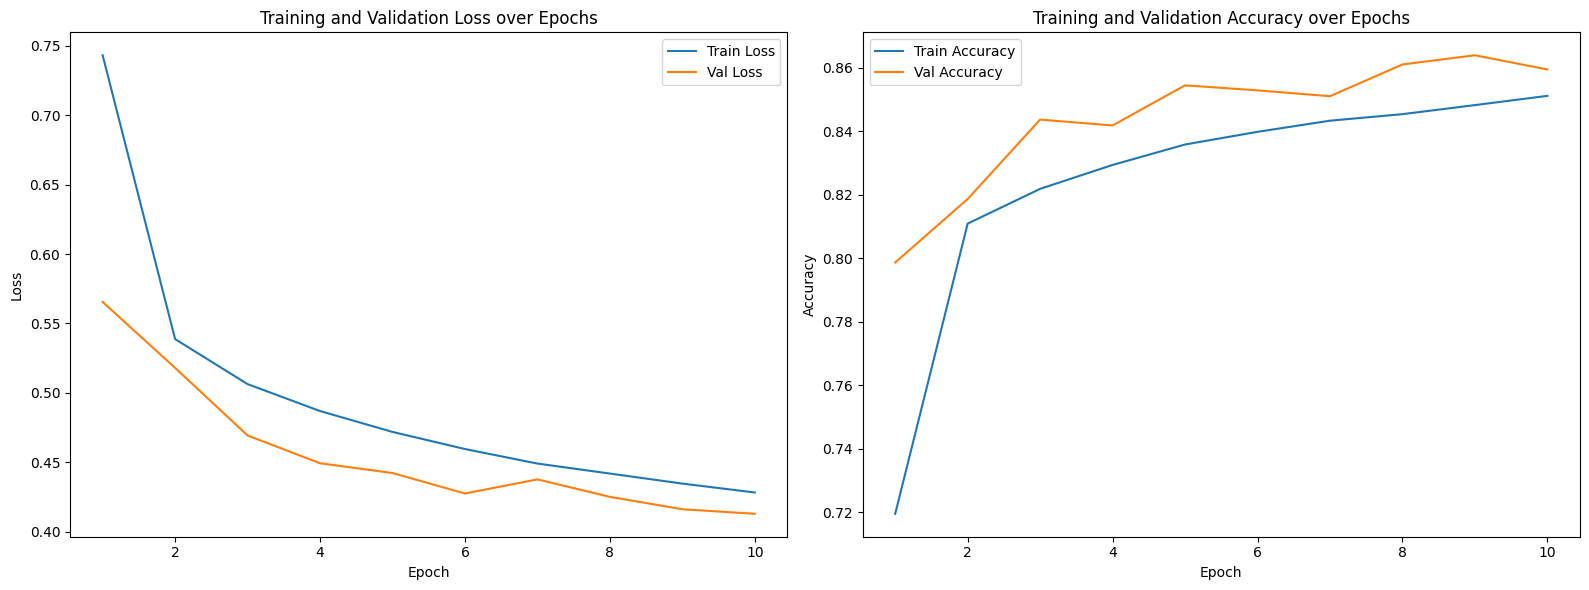

In [ ]:
# Plotting the graph
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get predictions for the test set
model_dropout.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_dropout(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_dropout(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {average_test_loss}, Test Accuracy: {test_accuracy}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
print(f"\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

Test Loss: 0.39657940177106055, Test Accuracy: 0.8623684210526316

Confusion Matrix:
[[822  51  46  26]
 [ 19 922  16   5]
 [ 52  45 748  64]
 [ 38  36 125 785]]

Precision: 0.8633830134632224, Recall: 0.8623684210526316, F1 Score: 0.8616606781712053


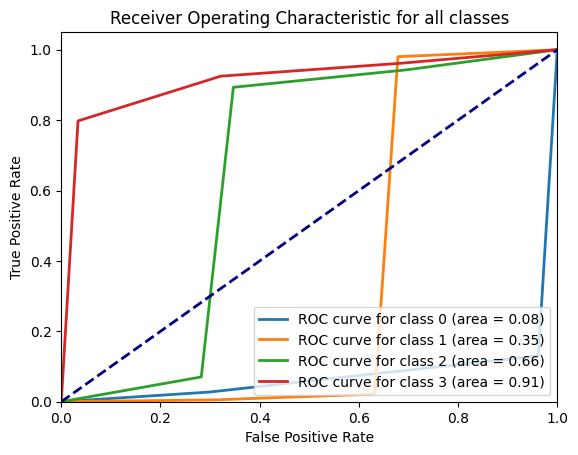

In [ ]:
plt.figure()
for i in range(4):  # Assuming there are four classes
    positive_class = i
    binary_labels = np.array([1 if label == positive_class else 0 for label in all_labels])
    fpr, tpr, _ = roc_curve(binary_labels, all_predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve for class {} (area = {:.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all classes')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Define a file path to save the model weights
model_path = "transformer_model_dropout.pth"

# Save the model weights
torch.save(model_dropout.state_dict(), model_path)

print("Training complete. Model weights saved.")

Training complete. Model weights saved.


## Early Stopping

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class TransformerClassifierEarlyStop(nn.Module):
    def __init__(self, embedding_matrix, num_classes, nhead, num_encoder_layers, dim_feedforward, max_seq_length, dropout_rate=0.1):
        super(TransformerClassifierEarlyStop, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.positional_encoding = nn.Parameter(self._generate_positional_encoding(max_seq_length, embedding_matrix.size(1)))
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_matrix.size(1), nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.output_layer = nn.Linear(embedding_matrix.size(1), num_classes)

    def forward(self, input_ids):
        embeddings = self.embedding(input_ids) + self.positional_encoding[:input_ids.size(1), :]
        embeddings = self.dropout(embeddings)  # Apply dropout after the embedding layer
        transformer_output = self.transformer_encoder(embeddings)
        cls_output = transformer_output.mean(dim=1)  # Use the mean of all tokens as the representation
        logits = self.output_layer(cls_output)
        return logits

    def _generate_positional_encoding(self, length, dim):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
        positional_encoding = torch.zeros(length, dim)
        positional_encoding[:, 0::2] = torch.sin(position * div_term)
        positional_encoding[:, 1::2] = torch.cos(position * div_term)
        return positional_encoding

In [ ]:
# Instantiate the model
model_early_stop = TransformerClassifierEarlyStop(word_embeddings.vectors, num_classes, nhead, num_encoder_layers, dim_feedforward, max_seq_length)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move the model to the GPU
model_early_stop.to(device)

Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerClassifierEarlyStop(
  (embedding): Embedding(400000, 100)
  (dropout): Dropout(p=0.1, inplace=False)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=100, out_features=100, bias=True)
        )
        (linear1): Linear(in_features=100, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=100, bias=True)
        (norm1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=100, out_features=4, bias=True)
)

In [ ]:
# Lists to store epoch-wise values
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

import numpy as np

# Initialize variables for early stopping
best_val_loss = float('inf')
best_epoch = 0
patience = 3  # Number of epochs to wait for improvement

# Training loop with early stopping
for epoch in range(num_epochs):
    model_early_stop.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train_predictions = 0
    total_train_predictions = 0
    optimizer = optim.SGD(model_early_stop.parameters(), lr=0.001, momentum=0.9)

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_early_stop(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_train_predictions += (predicted == labels).sum().item()
        total_train_predictions += labels.size(0)

    average_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train_predictions / total_train_predictions

    model_early_stop.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val_predictions = 0
    total_val_predictions = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_early_stop(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            running_val_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_predictions += val_labels.size(0)

    average_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val_predictions / total_val_predictions

    print(f"Epoch {epoch+1}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy}")

    # Store values for plotting
    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Early stopping
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_epoch = epoch
        torch.save(model_early_stop.state_dict(), 'best_model_early_stop.pth')  # Save the best model

    # Check if the validation loss hasn't improved for 'patience' epochs
    if epoch - best_epoch > patience:
        print("Validation loss hasn't improved for {} epochs. Early stopping...".format(patience))
        break

Epoch 1, Train Loss: 0.7478747682571412, Train Accuracy: 0.7164333333333334, Val Loss: 0.5494569026622451, Val Accuracy: 0.8005263157894736
Epoch 2, Train Loss: 0.5392661639134089, Train Accuracy: 0.8104, Val Loss: 0.49844614773237406, Val Accuracy: 0.8260526315789474
Epoch 3, Train Loss: 0.5089381734490395, Train Accuracy: 0.822025, Val Loss: 0.510542494033565, Val Accuracy: 0.8255263157894737
Epoch 4, Train Loss: 0.49020448307991027, Train Accuracy: 0.8297583333333334, Val Loss: 0.4774869609029353, Val Accuracy: 0.8260526315789474
Epoch 5, Train Loss: 0.47743079784909886, Train Accuracy: 0.83295, Val Loss: 0.45295047196520477, Val Accuracy: 0.8407894736842105
Epoch 6, Train Loss: 0.46461479318737986, Train Accuracy: 0.8383083333333333, Val Loss: 0.44083996342510734, Val Accuracy: 0.8497368421052631
Epoch 7, Train Loss: 0.45309044406612714, Train Accuracy: 0.841475, Val Loss: 0.44257281808292165, Val Accuracy: 0.8428947368421053
Epoch 8, Train Loss: 0.4456982660651207, Train Accuracy:

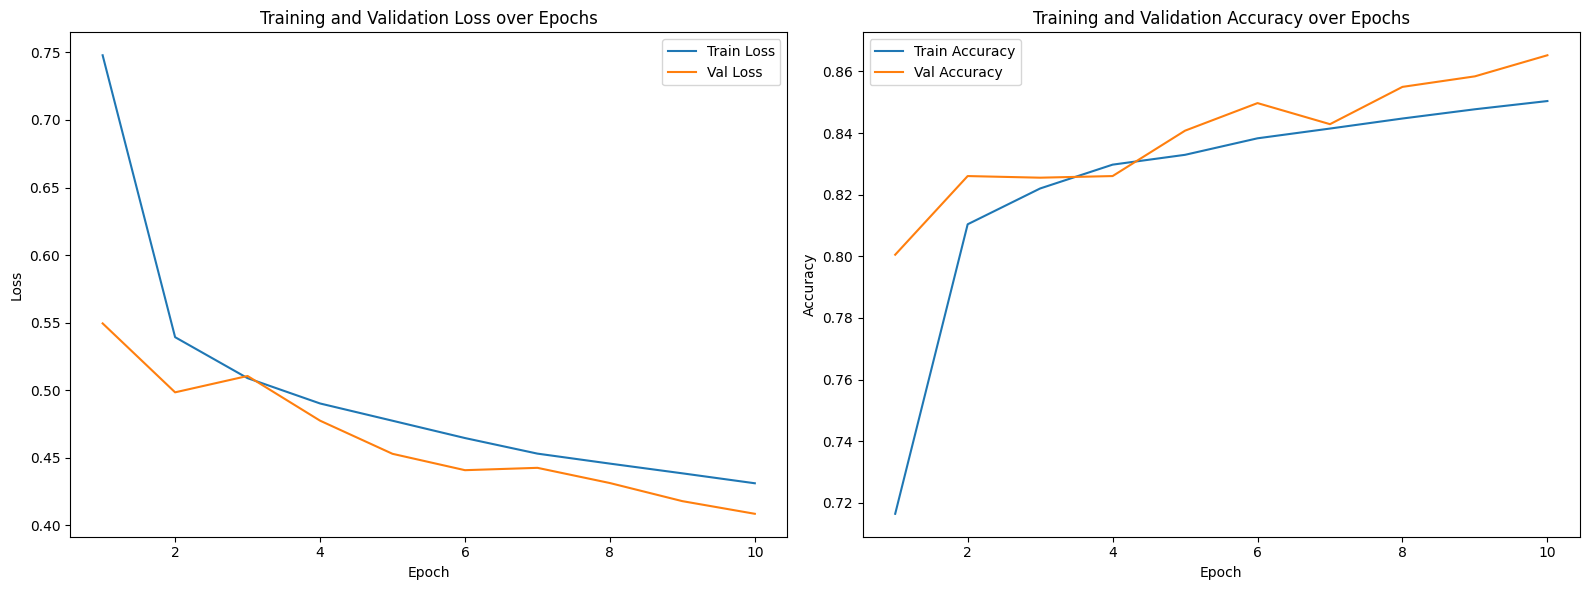

In [ ]:
# Plotting the graph
plt.figure(figsize=(16, 6))
# Code for plotting the graphs...

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Get predictions for the test set
model_early_stop.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_early_stop(inputs)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test loss and accuracy
test_loss = 0.0
correct_predictions = 0
total_predictions = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_early_stop(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

average_test_loss = test_loss / len(test_loader)
test_accuracy = correct_predictions / total_predictions
print(f"Test Loss: {average_test_loss}, Test Accuracy: {test_accuracy}")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Calculate precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
print(f"\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

Test Loss: 0.3906693081645405, Test Accuracy: 0.8689473684210526

Confusion Matrix:
[[825  38  47  35]
 [ 26 894  25  17]
 [ 41  25 740 103]
 [ 32  24  85 843]]

Precision: 0.8688181656683563, Recall: 0.8689473684210526, F1 Score: 0.8688131220549059


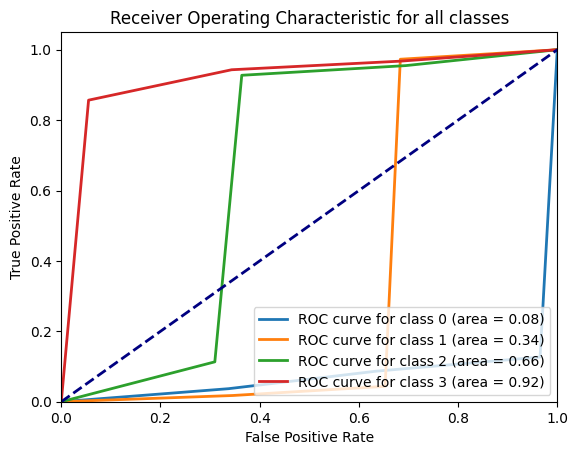

In [ ]:
plt.figure()
for i in range(4):  # Assuming there are four classes
    positive_class = i
    binary_labels = np.array([1 if label == positive_class else 0 for label in all_labels])
    fpr, tpr, _ = roc_curve(binary_labels, all_predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label='ROC curve for class {} (area = {:.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for all classes')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Define a file path to save the model weights
model_path = "transformer_model_early_stop.pth"

# Save the model weights
torch.save(model_early_stop.state_dict(), model_path)

print("Training complete. Model weights saved.")

Training complete. Model weights saved.


## Experimenting with different LR

In [ ]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Define the range of learning rates to experiment with
learning_rates = [0.001, 0.0005, 0.0001]

# Lists to store results for each learning rate
test_accuracies = []
train_losses_list = []
val_losses_list = []
train_accuracies_list = []
val_accuracies_list = []

for lr in learning_rates:
    # Instantiate the model
    model = TransformerClassifierEarlyStop(word_embeddings.vectors, num_classes, nhead, num_encoder_layers, dim_feedforward, max_seq_length)
    model.to(device)

    # Define your loss function and optimizer with the current learning rate
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    num_epochs = 5

    # Lists to store epoch-wise values
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Initialize variables for early stopping
    best_val_loss = float('inf')
    best_epoch = 0
    patience = 3  # Number of epochs to wait for improvement

    # Training loop with early stopping
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        correct_train_predictions = 0
        total_train_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train_predictions += (predicted == labels).sum().item()
            total_train_predictions += labels.size(0)

        average_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train_predictions / total_train_predictions
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()  # Set the model to evaluation mode
        running_val_loss = 0.0
        correct_val_predictions = 0
        total_val_predictions = 0

        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                running_val_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                correct_val_predictions += (val_predicted == val_labels).sum().item()
                total_val_predictions += val_labels.size(0)

        average_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val_predictions / total_val_predictions
        val_losses.append(average_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Learning Rate: {lr}, Epoch {epoch+1}, Train Loss: {average_train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {average_val_loss}, Val Accuracy: {val_accuracy}")

        # Early stopping
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            best_epoch = epoch
            best_model_path = f'best_model_lr_{lr}.pth'  # Save the best model with the learning rate in the filename
            torch.save(model.state_dict(), best_model_path)  # Save the best model

        # Check if the validation loss hasn't improved for 'patience' epochs
        if epoch - best_epoch > patience:
            print("Validation loss hasn't improved for {} epochs. Early stopping...".format(patience))
            break

    train_losses_list.append(train_losses)
    val_losses_list.append(val_losses)
    train_accuracies_list.append(train_accuracies)
    val_accuracies_list.append(val_accuracies)

    # Test the model with the best validation accuracy on the test set
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    correct_test_predictions = 0
    total_test_predictions = 0

    with torch.no_grad():
        for test_inputs, test_labels in test_loader:
            test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
            test_outputs = model(test_inputs)
            _, test_predicted = torch.max(test_outputs, 1)
            correct_test_predictions += (test_predicted == test_labels).sum().item()
            total_test_predictions += test_labels.size(0)

    test_accuracy = correct_test_predictions / total_test_predictions
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy (LR={lr}): {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Learning Rate: 0.001, Epoch 1, Train Loss: 0.7843698398709297, Train Accuracy: 0.6926916666666667, Val Loss: 0.555128377024867, Val Accuracy: 0.8026315789473685
Learning Rate: 0.001, Epoch 2, Train Loss: 0.5410177805026373, Train Accuracy: 0.8084666666666667, Val Loss: 0.5095260167071799, Val Accuracy: 0.8181578947368421
Learning Rate: 0.001, Epoch 3, Train Loss: 0.5103562728404999, Train Accuracy: 0.8215583333333333, Val Loss: 0.4754818791852278, Val Accuracy: 0.8292105263157895
Learning Rate: 0.001, Epoch 4, Train Loss: 0.4896159323771795, Train Accuracy: 0.8293333333333334, Val Loss: 0.4560015241638953, Val Accuracy: 0.8397368421052631
Learning Rate: 0.001, Epoch 5, Train Loss: 0.47696743226647376, Train Accuracy: 0.834475, Val Loss: 0.4682097895806577, Val Accuracy: 0.8381578947368421
Test Accuracy (LR=0.001): 0.8521052631578947
Learning Rate: 0.0005, Epoch 1, Train Loss: 0.8518301961580912, Train Accuracy: 0.6756916666666667, Val Loss: 0.5932313879998792, Val Accuracy: 0.79
Learni

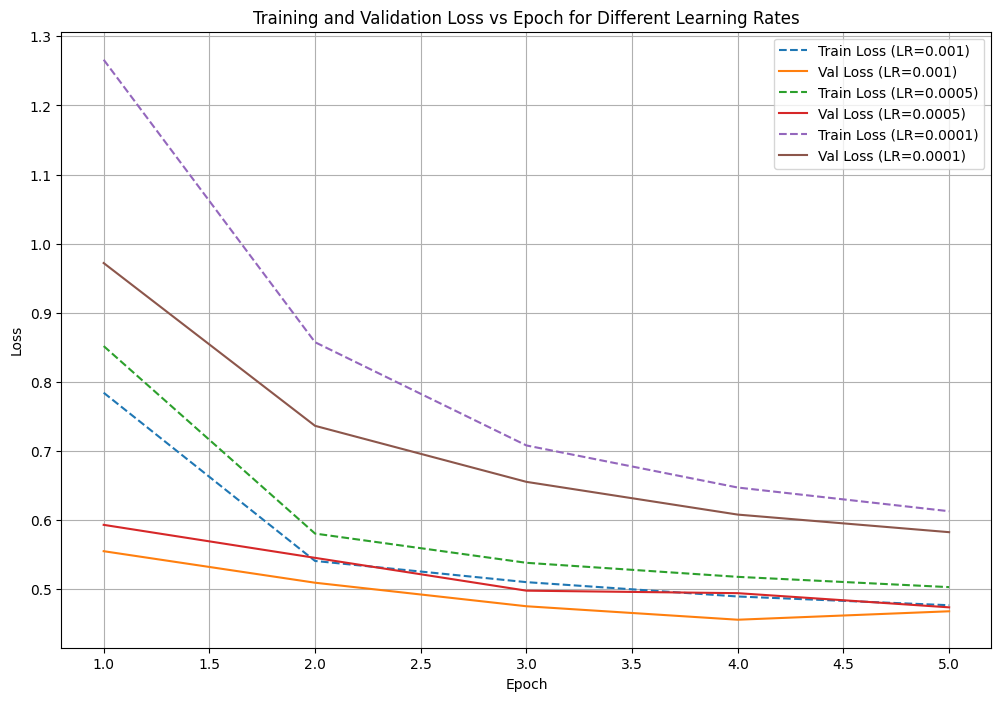

In [ ]:
# Plotting the training and validation loss for each learning rate
plt.figure(figsize=(12, 8))
for i, lr in enumerate(learning_rates):
    plt.plot(range(1, num_epochs + 1), train_losses_list[i], label=f'Train Loss (LR={lr})', linestyle='--')
    plt.plot(range(1, num_epochs + 1), val_losses_list[i], label=f'Val Loss (LR={lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

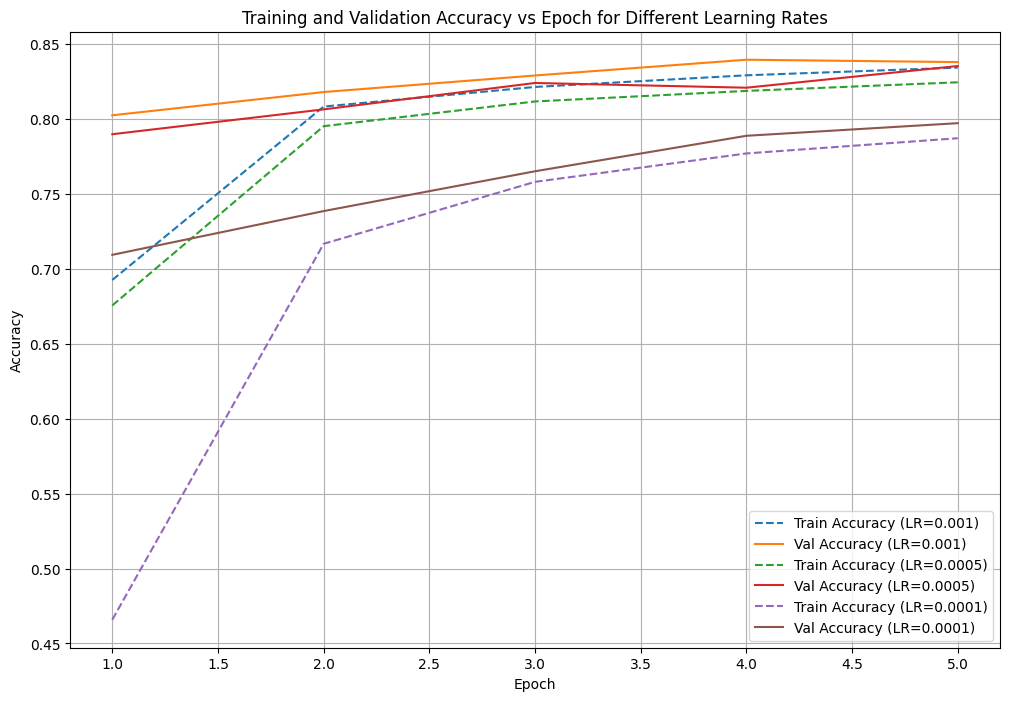

In [ ]:
# Plotting the training and validation accuracy for each learning rate
plt.figure(figsize=(12, 8))
for i, lr in enumerate(learning_rates):
    plt.plot(range(1, num_epochs + 1), train_accuracies_list[i], label=f'Train Accuracy (LR={lr})', linestyle='--')
    plt.plot(range(1, num_epochs + 1), val_accuracies_list[i], label=f'Val Accuracy (LR={lr})')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs Epoch for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Print test accuracies for each learning rate
for i, lr in enumerate(learning_rates):
    print(f"Test Accuracy (LR={lr}): {test_accuracies[i]}")

print("Training complete.")

Test Accuracy (LR=0.001): 0.8521052631578947
Test Accuracy (LR=0.0005): 0.8494736842105263
Test Accuracy (LR=0.0001): 0.8184210526315789
Training complete.
